In [1]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns

In [2]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 5.484 # MeV
which_data = 'som'

loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

plot_numbers = np.arange(0, 10)

# SONIK Data for 3He-4He elastic scattering

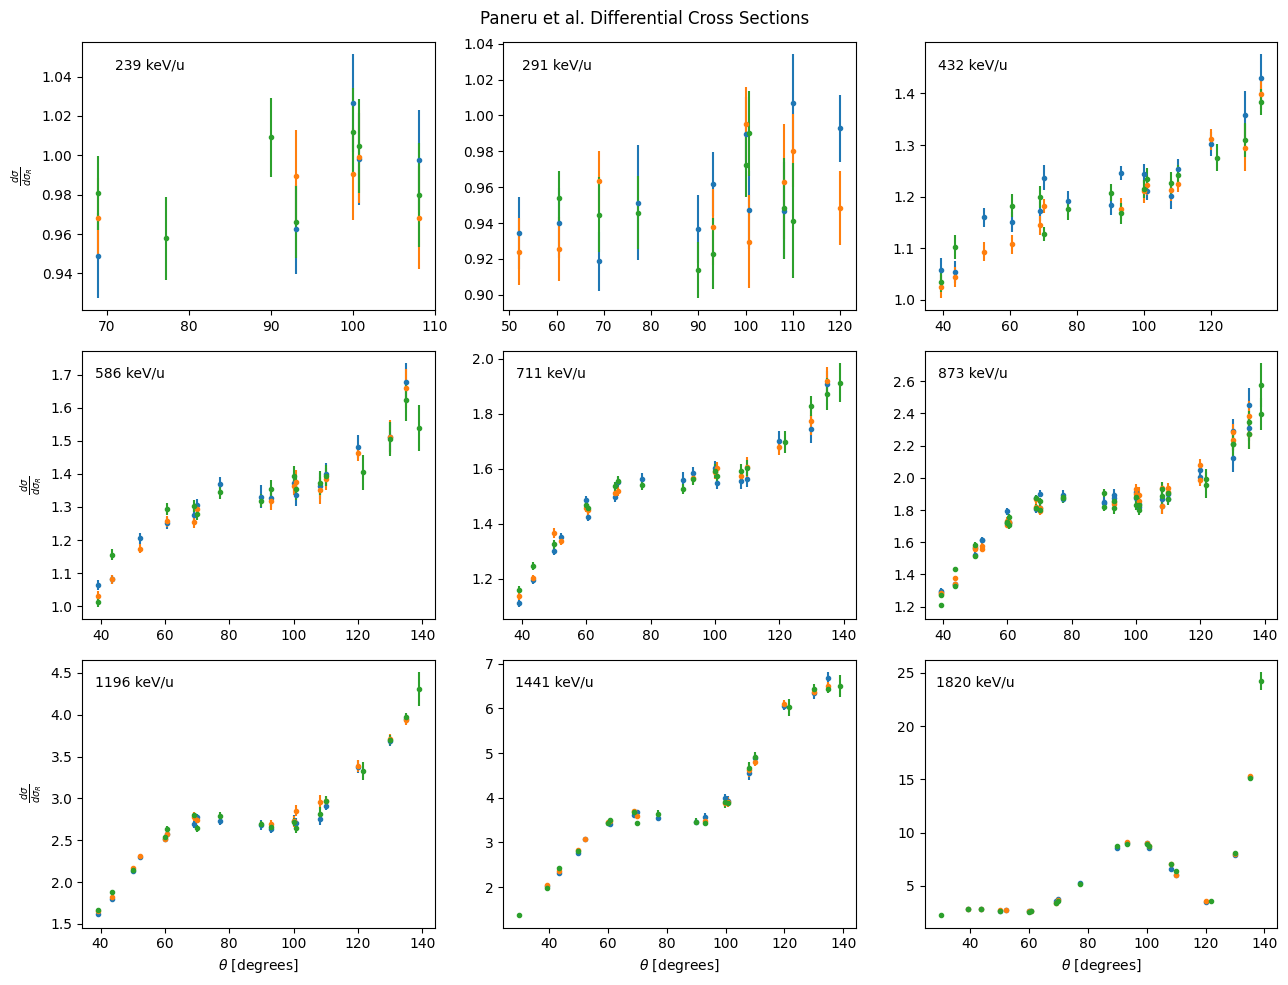

In [8]:
# Set up root path for the data
root_path = './'

# Set up the list of paths to the data
barnard_paths = [root_path + 'barnard_data/barnard5477.txt',
                root_path + 'barnard_data/barnard6345.txt',
                root_path + 'barnard_data/barnard7395.txt',
                root_path + 'barnard_data/barnard9003.txt',
                root_path + 'barnard_data/barnard10460.txt',
                root_path + 'barnard_data/barnard11660.txt',
                root_path + 'barnard_data/barnard12530.txt',
                root_path + 'barnard_data/barnard14080.txt']

som_paths = [root_path + 'SOM/som_cm_int1.npy',
            root_path + 'SOM/som_cm_int2.npy',
            root_path + 'SOM/som_cm_int3.npy']

# Load in the data, specific to the set and the E_max
data_E_max = E_max
data_which_data = which_data

# Handle Barnard set first
barnard_data_list = []
for path in barnard_paths:
    barnard_data_list.append(np.loadtxt(path))

# Handle Som set
som_data_list = []
l_som = [] # For Som normalization
l_som_energies = []
for path in som_paths:
    data_set = np.load(path, allow_pickle = True)
    som_data_list.append(data_set)
    l_som_energies.append([data_set[i][:, 0][0] for i in range(len(data_set))])
    l_som.append([len(data_set[j]) for j in range(len(data_set))])

# Concatenate the datasets into arrays
barnard_data = np.concatenate(barnard_data_list)
som_temp = np.concatenate(np.concatenate(som_data_list)) 
l_som_energies = np.array(l_som_energies)
# 2x concatenate because it is a list of lists

# For some reason, the Som data is formatted [E, theta, cs, err] so I swap the
# columns to match the Barnard set followint [theta, E, cs, err]
som_data = np.column_stack([som_temp[:, 1], som_temp[:, 0], som_temp[:, 2], som_temp[:, 3]])

# Cap the energy at E_max
# NOTE: The Barnard data has lowest E at 2.439 MeV and the Som data has
# lowest E at 0.676 MeV
if data_E_max != None:
    barnard_indices = np.where(barnard_data[:, 1] <= data_E_max)
    som_indices = np.where(som_data[:, 1] <= data_E_max)
    barnard_data = barnard_data[barnard_indices]
    som_data = som_data[som_indices]

# Now select which data to use
if data_which_data == 'both':
    data = np.concatenate([barnard_data, som_data])
elif data_which_data == 'som':
    data = som_data
elif data_which_data == 'barnard':
    data = barnard_data
else:
    sys.stderr.write('Choose a \'which_data\': both, som, barnard...')
    sys.exit(-1)

fig, ax = plt.subplots(3, 3, figsize = (13, 10))

coords = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [1, 2], [2, 0], [2, 1], [2, 2]])
descriptions = ['239 keV/u', '291 keV/u', '432 keV/u', '586 keV/u', '711 keV/u', '873 keV/u', '873 keV/u', '1196 keV/u', '1441 keV/u', '1820 keV/u']

# Plot the data
for j in plot_numbers:
    if j == 6:
        continue
    for energy in l_som_energies[:, j]:
        indices = np.where(data[:, 1] == energy)
        tmp = data[indices]
        ax[coords[j][0], coords[j][1]].errorbar(tmp[:, 0], tmp[:, 2], yerr = tmp[:, 3], fmt = '.')
    desc_y = ax[coords[j][0], coords[j][1]].get_ybound()[0] + (ax[coords[j][0], coords[j][1]].get_ybound()[1] - ax[coords[j][0], coords[j][1]].get_ybound()[0]) * 0.9
    desc_x = 4 + ax[coords[j][0], coords[j][1]].get_xbound()[0]
    ax[coords[j][0], coords[j][1]].text(desc_x, desc_y, descriptions[j])

ax[0, 0].set_ylabel('$\\frac{d \sigma}{d \sigma_{R}}$')
ax[1, 0].set_ylabel('$\\frac{d \sigma}{d \sigma_{R}}$')
ax[2, 0].set_ylabel('$\\frac{d \sigma}{d \sigma_{R}}$')

ax[2, 0].set_xlabel('$\\theta$ [degrees]')
ax[2, 1].set_xlabel('$\\theta$ [degrees]')
ax[2, 2].set_xlabel('$\\theta$ [degrees]')

plt.suptitle('Paneru et al. Differential Cross Sections')
plt.tight_layout()
plt.show()